In [1]:
import os
import pandas as pd
import numpy as np

C:\Users\USER\miniconda3\envs\pytorch1.8\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\USER\miniconda3\envs\pytorch1.8\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\USER\miniconda3\envs\pytorch1.8\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
folder = "data/pedestrian_traffic_data"
csv_path = os.path.join(folder, 'tracks.csv')

In [3]:
df = pd.read_csv(csv_path)

In [4]:
df = df.replace("None", np.nan) # 這個資料集很特別，用字串None來填在missing value的地方，所以我們要先處理一下。

col_with_na = df.columns[df.isnull().sum() > 0].tolist()

for col in col_with_na:
    df[col] = df[col].apply(lambda x: float(x))
    for value in df[col]:
        if isinstance(value, str):
            print(f"columns {col}, value - {value} - ")

In [5]:
col_ignore = ['other_oid', 'other_class', 'other_x', 'other_y']
remaining_cols = df.columns.difference(col_ignore, sort=False)

df2 = df.copy()
df2 = df2[remaining_cols]

In [6]:
df2.head()

,oid,timestamp,x,y,body_roll,body_pitch,body_yaw,head_roll,head_pitch,head_yaw
0,50187,1842.4,495854.640310,5.405751e+06,NaN,NaN,NaN,NaN,NaN,NaN
1,50187,1842.5,495854.792078,5.405751e+06,NaN,NaN,NaN,NaN,NaN,NaN
2,50187,1842.6,495854.943847,5.405751e+06,NaN,NaN,NaN,NaN,NaN,NaN
3,50187,1842.7,495855.095616,5.405751e+06,NaN,NaN,NaN,NaN,NaN,NaN
4,50187,1842.8,495855.256935,5.405751e+06,NaN,NaN,NaN,NaN,NaN,NaN


#### Numerical Imputation

`SKMiceImputer` + `LinearRegression` or `SKMiceImputer` + `KNeighborsRegressor`

In [7]:
from imputation.skmice_linear import SKMiceImputer

In [8]:
from sklearn.linear_model import LinearRegression

In [9]:
lr = LinearRegression()
imputer1 = SKMiceImputer()

In [10]:
X = df2.values
seeded_X, specs = imputer1.transform(X, model_class=lr)

In [11]:
type(seeded_X), type(specs)

(numpy.ndarray, numpy.ndarray)

In [12]:
seeded_X.shape, X.shape, specs.shape

((4759, 10), (4759, 10), (10, 10))

In [13]:
from sklearn.neighbors import KNeighborsRegressor

In [14]:
knn = KNeighborsRegressor()
imputer2 = SKMiceImputer()

In [15]:
seeded_X, specs = imputer2.transform(X, model_class=knn)

In [16]:
seeded_X.shape, X.shape, specs.shape

((4759, 10), (4759, 10), (10, 10))

`SKTreeMiceImputer` + `RandomForestRegressor`

In [17]:
from imputation.skmice_tree import SKTreeMiceImputer

In [18]:
from sklearn.ensemble import RandomForestRegressor

In [19]:
rf = RandomForestRegressor()
imputer3 = SKTreeMiceImputer()

In [20]:
seeded_X, specs = imputer3.transform(X, model_class=rf)

In [21]:
seeded_X.shape, X.shape, specs.shape

((4759, 10), (4759, 10), (10, 10))

#### Categorical Imputation

create a fake categorical column

In [22]:
!ls data

fake_categorical_data.xlsx
pedestrian
pedestrian_traffic_data
transportation


In [23]:
excel_folder = "data"
excel_path = os.path.join(excel_folder, "fake_categorical_data.xlsx")

In [24]:
df3 = pd.read_excel(excel_path)
df3.head()

,id,first_name,last_name,email,gender,ip_address
0,1,Mortie,Hillin,mhillin0@ocn.ne.jp,Male,208.148.126.55
1,2,Sissy,Spadaro,sspadaro1@baidu.com,Female,50.102.117.31
2,3,Cherice,Riha,criha2@edublogs.org,Female,98.154.106.199
3,4,Reggie,Kimbling,rkimbling3@wired.com,Female,46.95.201.124
4,5,Rasla,Southam,rsoutham4@tamu.edu,Female,238.223.59.182


In [25]:
import random

In [26]:
genders = df3['gender'].unique().tolist()
genders.append(np.nan)

In [27]:
def random_gender():
    return random.choice(genders)

In [28]:
df2['gender'] = [random_gender() for _ in range(len(df2))]
df2['gender'].value_counts(), df2['gender'].isnull().sum()

(Male           578
 Non-binary     553
 Polygender     539
 Genderqueer    528
 Agender        523
 Genderfluid    513
 Bigender       507
 Female         498
 Name: gender, dtype: int64,
 520)

`strategy="most_frequent"` + `SKMiceImputer`

In [29]:
from sklearn.preprocessing import OrdinalEncoder

In [30]:
enc = OrdinalEncoder()
df2['gender_enc'] = enc.fit_transform(df2[['gender']]) # nan value is nan after encoding

In [31]:
df2['gender_enc'].head()

0    6.0
1    3.0
2    1.0
3    1.0
4    6.0
Name: gender_enc, dtype: float64

In [32]:
imputer4 = SKMiceImputer(strategy="most_frequent")

In [33]:
col_need = remaining_cols.tolist().copy()
col_need.append('gender_enc')
X = df2[col_need].values
seeded_X, specs = imputer4.transform(X, model_class=lr)

In [34]:
seeded_X.shape, X.shape

((4759, 11), (4759, 11))

In [35]:
# inversed_imputed_gender = enc.inverse_transform(seeded_X[:,-1].reshape(-1,1))

In [36]:
# df2['gender_enc_imputed'] = inversed_imputed_gender
df2['gender_enc_imputed'] = seeded_X[:,-1]

In [37]:
df2.head()

,oid,timestamp,x,y,body_roll,body_pitch,body_yaw,head_roll,head_pitch,head_yaw,gender,gender_enc,gender_enc_imputed
0,50187,1842.4,495854.640310,5.405751e+06,NaN,NaN,NaN,NaN,NaN,NaN,Non-binary,6.0,6.0
1,50187,1842.5,495854.792078,5.405751e+06,NaN,NaN,NaN,NaN,NaN,NaN,Genderfluid,3.0,3.0
2,50187,1842.6,495854.943847,5.405751e+06,NaN,NaN,NaN,NaN,NaN,NaN,Bigender,1.0,1.0
3,50187,1842.7,495855.095616,5.405751e+06,NaN,NaN,NaN,NaN,NaN,NaN,Bigender,1.0,1.0
4,50187,1842.8,495855.256935,5.405751e+06,NaN,NaN,NaN,NaN,NaN,NaN,Non-binary,6.0,6.0


In [38]:
df2[df2['gender_enc'].isnull()].head()

,oid,timestamp,x,y,body_roll,body_pitch,body_yaw,head_roll,head_pitch,head_yaw,gender,gender_enc,gender_enc_imputed
21,50187,1844.5,495857.667218,5.405751e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
24,50187,1844.8,495858.043471,5.405751e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
29,50187,1845.3,495858.583247,5.405751e+06,0.0,0.0,178.4,0.00000,0.00000,195.910,NaN,NaN,5.0
53,50187,1847.7,495861.347753,5.405751e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
67,50187,1849.1,495863.059092,5.405752e+06,0.0,0.0,144.4,1.64938,4.12099,162.844,NaN,NaN,5.0


In [39]:
len(df2[df2['gender_enc'].isnull()])

520

In [40]:
df2[df2['gender_enc'].isnull()]['gender_enc_imputed'].value_counts()

5.0    520
Name: gender_enc_imputed, dtype: int64

In [41]:
df2['gender_enc_imputed'].value_counts()

5.0    1098
6.0     553
7.0     539
4.0     528
0.0     523
3.0     513
1.0     507
2.0     498
Name: gender_enc_imputed, dtype: int64

### Test evaluation metrics

In [42]:
from imputation.evaluate2 import ImpEvaluator

In [43]:
original_cols = ['oid', 'timestamp', 'x', 'y', 'gender_enc']
imputed_cols = ['oid', 'timestamp', 'x', 'y', 'gender_enc_imputed']

In [44]:
missing_mask = df2[original_cols].isna().values
categorical_indices = [4]  # Indices of categorical columns
evaluator = ImpEvaluator(
    original=df2[original_cols].values, 
    imputed=df2[imputed_cols].values, 
    missing_mask=missing_mask, 
    categorical_indices=categorical_indices
)

In [45]:
ks_p_values, js_divergences, cat_accuracies = evaluator.evaluate_distribution_similarity()

In [46]:
print("Kolmogorov-Smirnov Test P-values:", ks_p_values)
print("Jensen-Shannon Divergence Scores:", js_divergences)
print("Categorical Accuracy:", cat_accuracies)

Kolmogorov-Smirnov Test P-values: [1.0, 1.0, 1.0, 1.0]
Jensen-Shannon Divergence Scores: [0.0, 0.0, 0.0, 0.0]
Categorical Accuracy: [1.0]


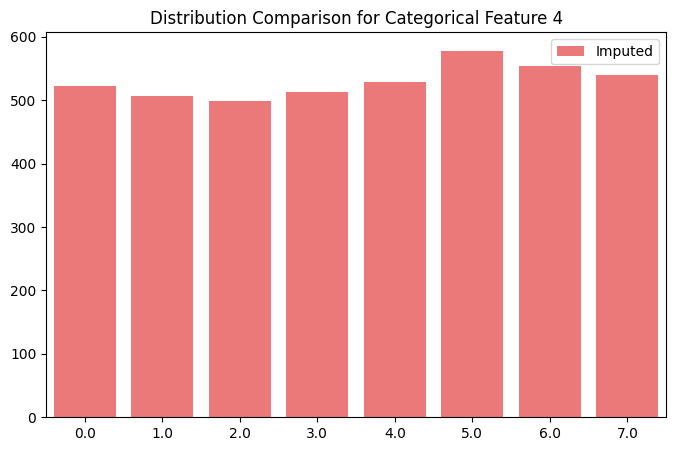

In [47]:
# evaluator.plot_numerical_distributions()
evaluator.plot_categorical_distributions()